In [26]:
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy import linalg
from numba import njit

On considère dans ce cas l'équation de Burgers suivante:
\begin{equation}
    \begin{cases}
    & \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = 0 \quad \text{pour} \quad t > 0, \quad x \in [l, L]\\
    & u(x,0)=u_0(x) \quad \forall x \in [l,L]
    \end{cases}
\end{equation}

In [38]:


#La Solution Iniciale:
@njit
def u0(x):
    if  x <=l+ (L-l)/4:
        return ul
    if  x >l+ (L-l)/4 and x <l+ 3*(L-l)/4:
        return um
    else:
        return ur


# La Solution Exacte:
@njit
def Uex(t,x):
    if x>=l and x<=0.5*(L+l):
        if x-(l+ (L-l)/4)<= ul*t:
            return ul

        elif x-(l+ (L-l)/4)>ul*t and x-(l+ (L-l)/4)< um*t:
            return (x-(l+ (L-l)/4))/t

        elif x-(l+ (L-l)/4)>=um*t:
            return um
    else:
        if x-(l+ 3*(L-l)/4)<0.5*(um+ur)*t:
            return um
        else:
            return ur

# Le flux Exacte:
@njit
def F(u):
    return (u**2)/2

# Les Flux des schemas:
@njit
def Rusanov(ug,ud,dx,dt):
    lamda= max(abs(ug),abs(ud))
    return 0.5*(F(ug)+F(ud))-lamda*(ud-ug)

@njit
def Rusanov2(ug,ud,dx,dt):
    lamda= max(abs(ug),abs(ud))
    return 0.5*(F(ug)+F(ud)-lamda*(ud-ug))

@njit
def Roe(ug,ud,dx,dt):
    return 0.5 *( (F(ug)+F(ud)) - (ug+ud)/2 *(ud-ug) )
  
@njit
def LF(ug,ud,dx,dt):
    return 0.5 *( (F(ug)+F(ud)) - (dx/dt) *(ud-ug) )

@njit
def LFM(ug,ud,dx,dt):
    return 0.5 *( (F(ug)+F(ud)) - 0.5*(dx/dt) *(ud-ug) )

@njit
def LW(ug, ud, dx, dt):
    A = 0.5 * (ud + ug)
    return 0.5 * (F(ug) + F(ud) - (dt / dx) * A * (F(ud) - F(ug)))

@njit
def departure(dt, alpha, X, u):
    aux = 1.0
    eps = 1e-9

    x0 = 0.5 * (X[:-1] + X[1:])
    xmp = x0
    kit = 0

    while aux > eps:
        x1 = xmp - dt * alpha * np.max(u)
        aux = np.max(np.abs(x1 - x0))

        x0 = x1
        kit += 1

    return x0, kit

@njit
def FvcFlux(N, X, alpha, dt, u):
    F = np.zeros(N - 1)
    up = np.zeros(N - 1)
    
    # Characteristics foot
    x0, _ = departure(dt, alpha, X, u)

    # Interpolation procedure
    ui = np.interp(x0, X, u)

    # Predictor stage
    for i in range(N - 1):
        up[i] = ui[i]

    # Corrector stage
    for i in range(N - 1):
        F[i] = 0.5 * up[i]**2

    return F

@njit
def VFC(U0, T,  N,  alpha, dx, CFL):
    Un    = U0.copy()
    Unp1  = np.zeros(N)
    temps = 0
    
    while temps < T:
        Dt  = CFL*(dx/(2*np.max(np.abs(Un))*alpha))

        temps += min(Dt,T-Dt)
        for i in range(1,N-1):
            X1 = X[i-1:i+2]
            u  = Un[i-1:i+2]
            F  = FvcFlux(3, X1, alpha, Dt, u)
            Fg = F[0]
            Fd = F[1]
            Unp1[i]=Un[i]-Dt/dx*(Fd-Fg)

        Unp1[0] = Unp1[1]
        Unp1[N-1] = Unp1[N-2]
        Un = Unp1.copy()
    return Un


@njit
def NonLinearBurgerSolver(U0, T, l, L, N, dx, CFL, scheme):
    if scheme == 0:
        flux = Roe 
    elif scheme == 1:
        flux = Rusanov
    elif scheme == 2:
        flux = Rusanov2
    elif scheme == 3:
        flux = LF
    elif scheme == 4:
        flux = LFM
    elif scheme == 5:
        flux = LW
    

    Un = U0.copy()
    Unp1 = np.zeros(N)
    temps = 0
    while temps < T:
        dt = CFL*dx/np.max(np.abs(Un))
        temps += min(dt,T-dt)
        for i in range(1,N-1):
            Fd = flux(Un[i],Un[i+1],dx,dt)
            Fg = flux(Un[i-1],Un[i],dx,dt)
            Unp1[i] = Un[i]-dt/dx*(Fd-Fg)

        Unp1[0] = Unp1[1]
        Unp1[N-1] = Unp1[N-2]


        Un = Unp1.copy()
        

    return Un

###################################################################################
ul = 0.2
um = 0.8
ur = 0.4
T=1/4
l=0
L=1
a=2
N=101
CFL=1/2
alpha = 0.7
X = np.linspace(l,L,N)
dx = (L-l)/(N-1)
U0=np.array([u0(x) for x in X])

f = {}

fluxes = {("Roe",0):1, ("Rusanov",1):1, ("Rusanov2",2):1, ("LF",3):1, ("LFM",4):1, ("LW",5):1}

for i,j in fluxes.items():  
    if j:
        f[i[0]]  =  NonLinearBurgerSolver  (U0, T, l, L, N, dx, CFL, i[1])   
    
U_VFC = VFC(U0, T,  N,  alpha, dx, CFL)
UExact = np.array([Uex(T,x) for x in X])

/tmp/ipykernel_51384/3061598154.py:148: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for i in range(1,N-1):


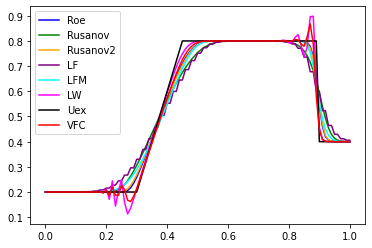

In [39]:
PLOT = {"Roe":1, "Rusanov":1, "Rusanov2":1, "LF":1, "LFM":1, "LW":1, }

colors = ['blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'brown']


for i, (flux, Un) in enumerate(f.items()) :
    k = list(PLOT)[i]
    if PLOT[k]:
        plt.plot(X, Un, '-', label=flux, color=colors[i])
    
plt.plot(X, UExact, '-k',  label='Uex')
plt.plot(X, U_VFC, '-r',  label='VFC')

#plt.xlim([0.6, 0.9])  
#plt.ylim([0.6, 0.9])  

plt.legend()
plt.pause(0.1)


In [40]:
Norm = {}
for i, (flux, Un) in enumerate(f.items()):
    Norm[flux]    =  np.linalg.norm(Un,ord = 2) 
Norm

{'Roe': 5.904222359310444,
 'Rusanov': 5.8589619439259275,
 'Rusanov2': 5.899066941203991,
 'LF': 5.834440218660377,
 'LFM': 5.882116054685976,
 'LW': 5.94874335071809}